In [25]:
import numpy as np


def solve_u(N, t):
    h = 1 / N
    T = N * t
    u = np.zeros((N + 1, T + 1))
    # u[:,0]=0
    u[0, :] = 10
    u[N, :] = 10
    for j in range(T + 1):
        for i in range(N + 1):
            if i != 0 and i != N and j != 0:
                u[i, j] = u[i, j - 1] + (u[i - 1, j - 1] - 2 * u[i, j - 1] + u[i + 1, j - 1]) / 1000 / h

    return u




/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


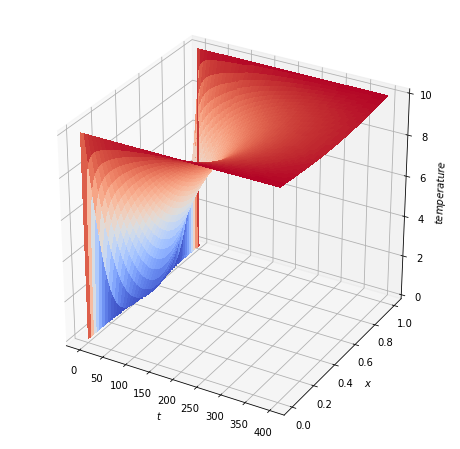

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import math

from scipy.sparse.linalg import spsolve

N = 500
t = 400

sol = solve_u_gpu(N, t)
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ticksX = np.linspace(0, t, N * t + 1)
ticksY = np.linspace(0, 1, N + 1)
X, Y = np.meshgrid(ticksX, ticksY)
surf = ax.plot_surface(X, Y, sol, antialiased=False, cmap=cm.coolwarm)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_zlabel(r'$temperature$')

plt.show()



* plot the temperature of the rod at *t=1, t=2* and *t=10* .

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

Ts = [1, 2, 10, 120]
N = 66

fig, ax = plt.subplots(len(Ts), 1, figsize=(7, len(Ts) * 3.5))
u = solve_u_gpu(N, np.max(Ts))

x = np.linspace(0, 1, N + 1)

for count, t in enumerate(tqdm(Ts)):
    ax[count].plot(x, u[:, t], 'c+-')
    ax[count].set_title('t=' + str(t))

plt.show()

In [64]:
import numba
import numpy as np
from numba import cuda
from scipy.sparse import coo_matrix


def solve_u_gpu(N, t):
    T = N * t
    h=1/N
    block_per_grid = 5
    t_per_block_i = (N + 1) // block_per_grid + 1   #最后一个拿来加j

    blocks = (block_per_grid, 1)
    threads = (t_per_block_i, 1)

    @cuda.jit
    def kernel(u, j):

        tx = cuda.threadIdx.x
        px = cuda.grid(1)
        if px >= N + 1 or j >= T + 1:
            return


        elif px != 0 and px != N and j != 0:
            u[px, j] = u[px, j - 1] + (u[px - 1, j - 1] - 2 * u[px, j - 1] + u[px + 1, j - 1]) / 1000 / h

        cuda.syncthreads()
        

    # print('blocks/grid: {0} ({2}*{2})\nthreads/block: {1} ({3}*{3})'.format(block_per_grid ** 2, t_per_block ** 2,
    #                                                                         block_per_grid, t_per_block))
    u = cuda.device_array(shape=(N + 1, T + 1), dtype=np.float32)
    u[:, 0] = 0
    u[0, :] = 10
    u[N, :] = 10
    for j in range (1,T+1):
      kernel[blocks, threads](u, j)

    u = u.copy_to_host()

    return u


In [ ]:
def cuda_init():
    cuda.detect()
    a = cuda.device_array(shape=(2, 2), dtype=np.float32)
    print('Initialization complete')

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


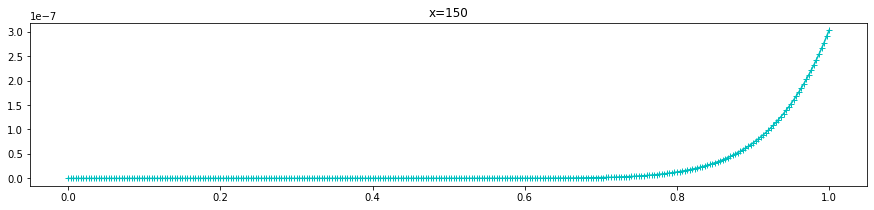

In [56]:
from tqdm import tqdm
import matplotlib.pyplot as plt

N = 300
x=N//2
t=1
T=N*t

plt.figure(figsize=(15, 3))
u = solve_u_gpu(N, t)

t = np.linspace(0, t, T + 1)
plt.plot(t, u[x,:], 'c+-')
plt.title('x=' + str(x))

plt.show()